# Imports

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import collections
import scipy
import operator
from functools import reduce
import community as cmt
from networkx.algorithms.community import greedy_modularity_communities
import seaborn as sns
from sklearn.mixture import GaussianMixture as GMM
import random
sns.set(rc={'figure.figsize':(16,9)})
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Datasets

<Big> <u>Routes</u></Big>

As of June 2014, the OpenFlights/Airline Route Mapper Route Database contains 67663 routes between 3321 airports on 548 airlines spanning the globe.
- **Airline**	2-letter (IATA) or 3-letter (ICAO) code of the airline.
- **Airline ID**	Unique OpenFlights identifier for airline (see Airline).
- **Source airport**	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
- **Source airport ID**	Unique OpenFlights identifier for source airport (see Airport)
- **Destination airport**	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
- **Destination airport ID**	Unique OpenFlights identifier for destination airport (see Airport)
- **Codeshare**	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
- **Stops**	Number of stops on this flight ("0" for direct)
- **Equipment**	3-letter codes for plane type(s) generally used on this flight, separated by spaces<br>
The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.<br>
**Notes**:
- Routes are directional: if an airline operates services from A to B and from B to A, both A-B and B-A are listed separately.
- Routes where one carrier operates both its own and codeshare flights are listed only once.


<Big><u>Airports</u></Big>

As of January 2017, the OpenFlights Airports Database contains over **10,000 airports, train stations and ferry terminals spanning the globe, as shown in the map above. Each entry contains the following information:

- **Airport ID**	Unique OpenFlights identifier for this airport.
- **Name**	Name of airport. May or may not contain the City name.
- **City**	Main city served by airport. May be spelled differently from Name.
- **Country**	Country or territory where airport is located. See countries.dat to cross-reference to ISO 3166-1 codes.
- **IATA**	3-letter IATA code. Null if not assigned/unknown.
- **ICAO**	4-letter ICAO code. Null if not assigned.
- **Latitude**	Decimal degrees, usually to six significant digits. Negative is South, positive is North.
- **Longitude**	Decimal degrees, usually to six significant digits. Negative is West, positive is East.
- **Altitude**	In feet.
- **Timezone**	Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.
- **DST**	Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time
- **Tz** database time zone	Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".
- **Type**	Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.
- **Source**	In airports.csv, only source=OurAirports is included.
The data is UTF-8 encoded.

Note: Rules for daylight savings time change from year to year and from country to country. The current data is an approximation for 2009, built on a country level. Most airports in DST-less regions in countries that generally observe DST (eg. AL, HI in the USA, NT, QL in Australia, parts of Canada) are marked incorrectly.

## Loading Datasets

In [4]:
routes = pd.read_csv('routes.dat', header=None)
routes.columns = ['Airline', 'Airline ID', 
                'Source airport', 'Source airport ID',
                'Destination airport', 'Destination airport ID',
                'Codeshare', 'Stops', 'Equipment']

In [5]:
airports = pd.read_csv('airports.dat', header=None, index_col=4, na_values='\\N')
airports.columns = ['Airport ID', 'Name', 'City', 'Country',
                    'ICAO', 'Latitude', 'Longitude', 'Altitude',
                    'Timezone', 'DST', 'TZ', 'Type', 'Source']

In [6]:
routes.head()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [7]:
airports.head()

,Airport ID,Name,City,Country,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TZ,Type,Source
4,,,,,,,,,,,,,
GKA,1,Goroka Airport,Goroka,Papua New Guinea,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
MAG,2,Madang Airport,Madang,Papua New Guinea,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
HGU,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
LAE,4,Nadzab Airport,Nadzab,Papua New Guinea,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
POM,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports


## Data Cleaning

We start by finding the common airports between both datasets (routes and airports)

In [8]:
# Find common airports
airports_route = list(set(set(routes['Source airport']) | set(routes['Destination airport'])))
airports_codes = list(airports.index)
nodes = list(set(airports_codes) & set(airports_route))

# We keep the edges that are connected to known source and destination airports
routes_clean = routes[(routes['Source airport'].isin(nodes)) & routes['Destination airport'].isin(nodes)]
airports_clean = airports[airports.index.isin(nodes)]

Next, we add the latitude and longitude for source and destination airports and the distance between them.

In [9]:
routes_clean['Source latitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Latitude.values.item(0), axis = 1)
routes_clean['Source longitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Longitude.values.item(0), axis = 1)
routes_clean['Destination latitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Latitude.values.item(0), axis = 1)
routes_clean['Destination longitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Longitude.values.item(0), axis = 1)
routes_clean['Distance'] = routes_clean.apply(lambda row : geodesic((row['Source latitude'], row['Source longitude']), (row['Destination latitude'], row['Destination longitude'])).kilometers, axis = 1)

In [10]:
routes_clean.head()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment,Source latitude,Source longitude,Destination latitude,Destination longitude,Distance
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2,43.449902,39.956600,55.606201,49.278702,1507.989717
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2,46.283298,48.006302,55.606201,49.278702,1040.943207
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2,46.283298,48.006302,44.225101,43.081902,449.036664
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2,55.305801,61.503300,55.606201,49.278702,773.126239
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2,55.305801,61.503300,55.012600,82.650703,1343.161122


Save cleaned data

In [11]:
routes_clean.to_csv('routes_clean.csv', index=False)
airports_clean.to_csv('airports_clean.csv')

# Data Exploration

## Load clean datasets

In [12]:
routes = pd.read_csv('routes_clean.csv')
airports = pd.read_csv('airports_clean.csv', index_col=0)

## Create graph from list of edges

In [13]:
G = nx.from_pandas_edgelist(routes, 'Source airport', 'Destination airport', ['Distance'])

## Graph Statistics

### Average Degree

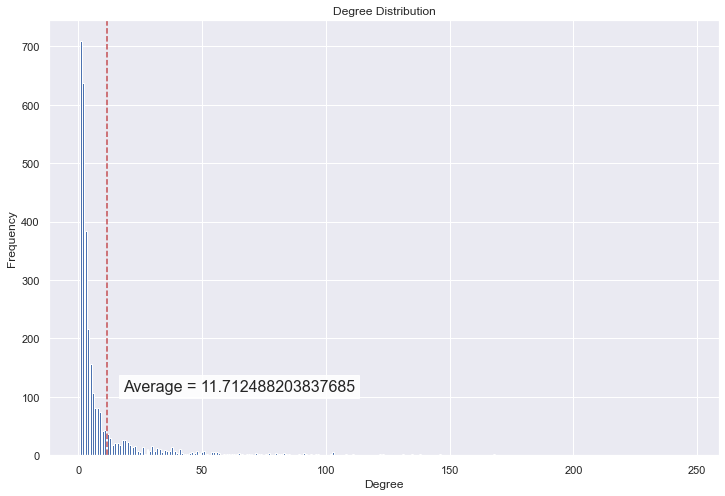

In [14]:
degree_distribution = sorted([d for n, d in G.degree()], reverse=True)
# print(f"Degree Distribution: {degree_distribution}")

degreeCount = collections.Counter(degree_distribution)
degree, count = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(12, 8))
plt.bar(degree, count, color='b')
# plt.loglog(degree, count, color='b')
avg_degree = np.array(degree_distribution).mean()
plt.axvline(avg_degree, color='r', linestyle='dashed')
plt.title('Degree Distribution')
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.text(18, 110, 'Average = {}'.format(avg_degree), bbox=dict(facecolor='white', alpha=0.9), fontsize=16)
plt.show()

In [15]:
print(f"The average degree distribution is: {avg_degree}")

The average degree distribution is: 11.712488203837685


### Graph Connectivity

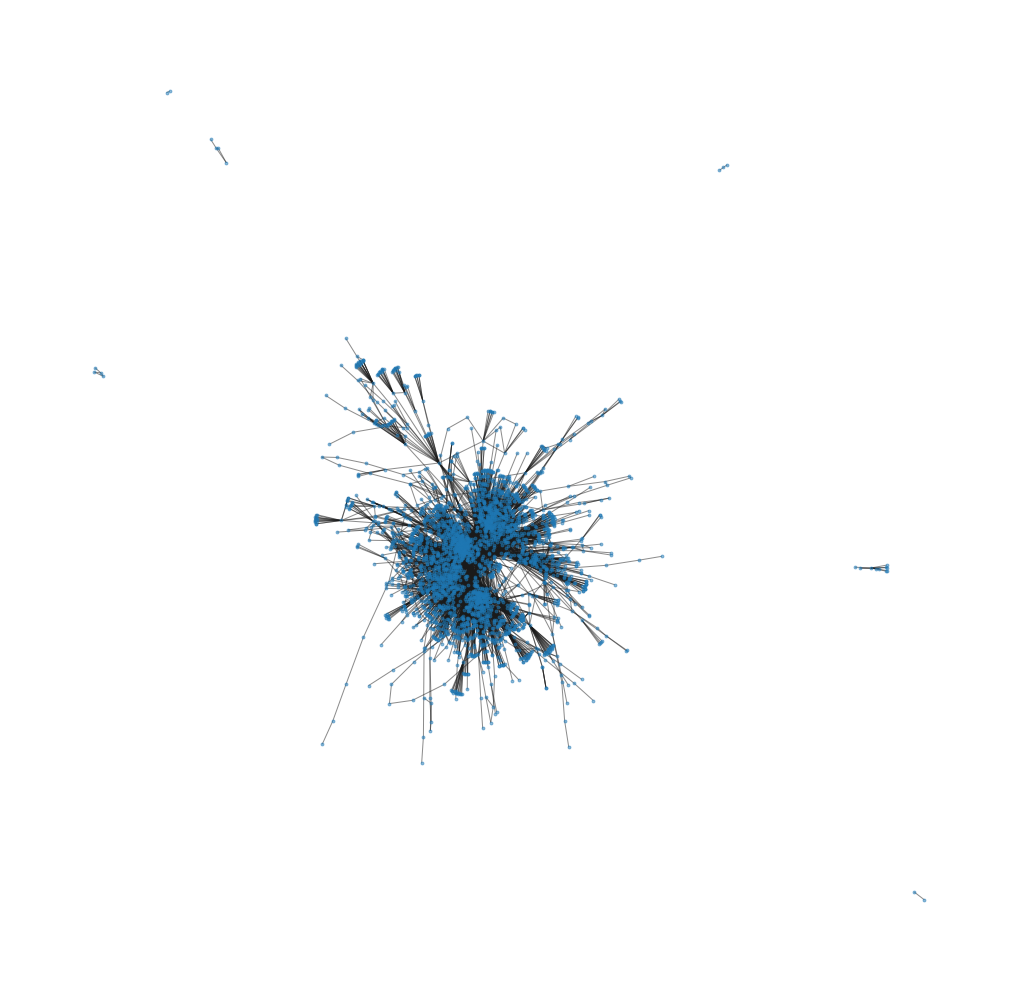

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_networkx(G, ax=ax, node_size=8, with_labels=False, alpha=.5)
ax.set_facecolor('xkcd:white')

We can see that the network is not fully connected

In [17]:
print(f"There are {nx.number_connected_components(G)} different components")

There are 7 different components


Since the graph is not fully connected, we're going to extract the largest connected component.

In [18]:
largest_cc = G.subgraph(max(nx.connected_components(G), key=len))
print(f"The largest component contains {len(largest_cc)} nodes")

The largest component contains 3154 nodes


### Largest Component Diameter

The diameter of the graph is the length of the longest shortest path between any pair of nodes.

In [19]:
print(f"The diameter of the graph is: {nx.diameter(largest_cc)}")

The diameter of the graph is: 12


### Clustering Coefficient

**The neighborhood of a node *u*, is the set of nodes that are connected to it.**

The clustering coefficient of a node ***u*** is the fraction of the node's neighbors that are connected. 

In [20]:
print(f"The graph has a clustering coefficient of: {nx.average_clustering(largest_cc)}")

The graph has a clustering coefficient of: 0.49144436995862


### Centrality

Centrality is a measure of importance of nodes/edges in a network

In [21]:
def get_NameCity(ID):
    row = airports.loc[ID]
    return row['Name'], row['City']

def plot_dict(dict_, k, name):

    def print_rank(l):
        for k in range(len(l)):
            a, b = get_NameCity(l[k])
            print(f"{k+1}. {a}, {b}")

    airports, values = list(dict_.keys()), list(dict_.values())
    sort_index = list(np.argsort(values))
    airports_s = np.array(airports)[sort_index][::-1] #k highest ranked
    values_s = np.array(values)[sort_index][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(14,12))
    ax.set_facecolor('xkcd:white')
    sns.barplot(ax=ax, x=airports_s[:k], y=values_s[:k], palette='rocket', label='small')
    print(f"In terms of {name}, the top {k} nodes are:\n")
    print_rank(airports_s[:k])
    return list(zip(airports_s, np.array(range(len(airports_s)))+1))

**Betweenness Centrality**:

Betweenness centrality measures how much nodes/edges are part of the shortest paths.

In terms of betweenness, the top 15 nodes are:

1. Charles de Gaulle International Airport, Paris
2. Los Angeles International Airport, Los Angeles
3. Dubai International Airport, Dubai
4. Ted Stevens Anchorage International Airport, Anchorage
5. Frankfurt am Main International Airport, Frankfurt
6. Amsterdam Airport Schiphol, Amsterdam
7. Beijing Capital International Airport, Beijing
8. Chicago O'Hare International Airport, Chicago
9. Lester B. Pearson International Airport, Toronto
10. Atatürk International Airport, Istanbul
11. Guarulhos - Governador André Franco Montoro International Airport, Sao Paulo
12. London Heathrow Airport, London
13. Narita International Airport, Tokyo
14. Sydney Kingsford Smith International Airport, Sydney
15. Seattle Tacoma International Airport, Seattle


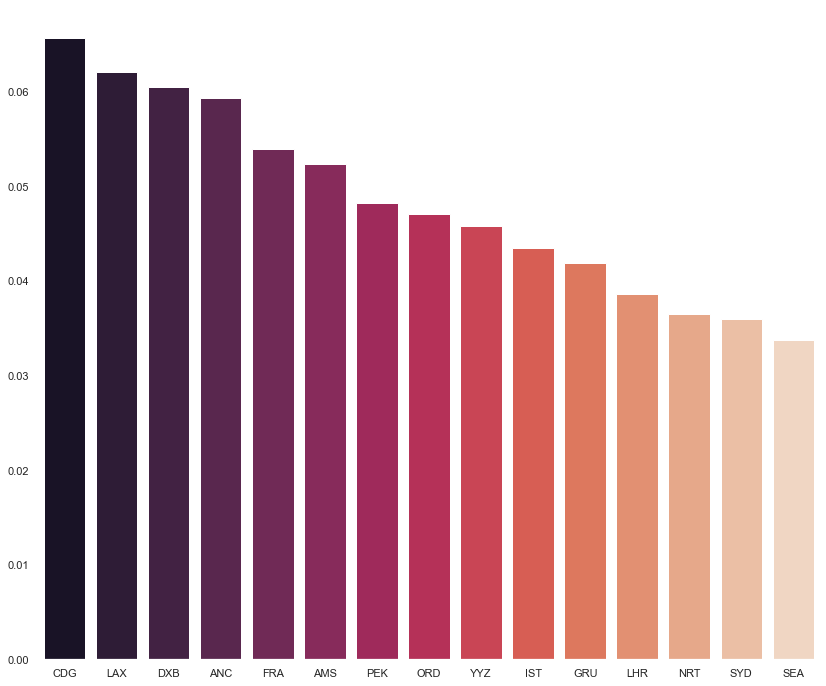

In [22]:
betweenness = nx.betweenness_centrality(largest_cc)
sorted_betw = plot_dict(betweenness, 15, 'betweenness')

**Eigenvalue Centrality**:

Eigenvalue centrality measures how much nodes are connected to nodes with high betweenness centrality.

In terms of eigenvectors, the top 15 nodes are:

1. Amsterdam Airport Schiphol, Amsterdam
2. Frankfurt am Main International Airport, Frankfurt
3. Charles de Gaulle International Airport, Paris
4. Munich International Airport, Munich
5. Leonardo da Vinci–Fiumicino Airport, Rome
6. London Heathrow Airport, London
7. Barcelona International Airport, Barcelona
8. Atatürk International Airport, Istanbul
9. Zürich Airport, Zurich
10. Adolfo Suárez Madrid–Barajas Airport, Madrid
11. Brussels Airport, Brussels
12. Dublin Airport, Dublin
13. Düsseldorf International Airport, Duesseldorf
14. London Gatwick Airport, London
15. Manchester Airport, Manchester


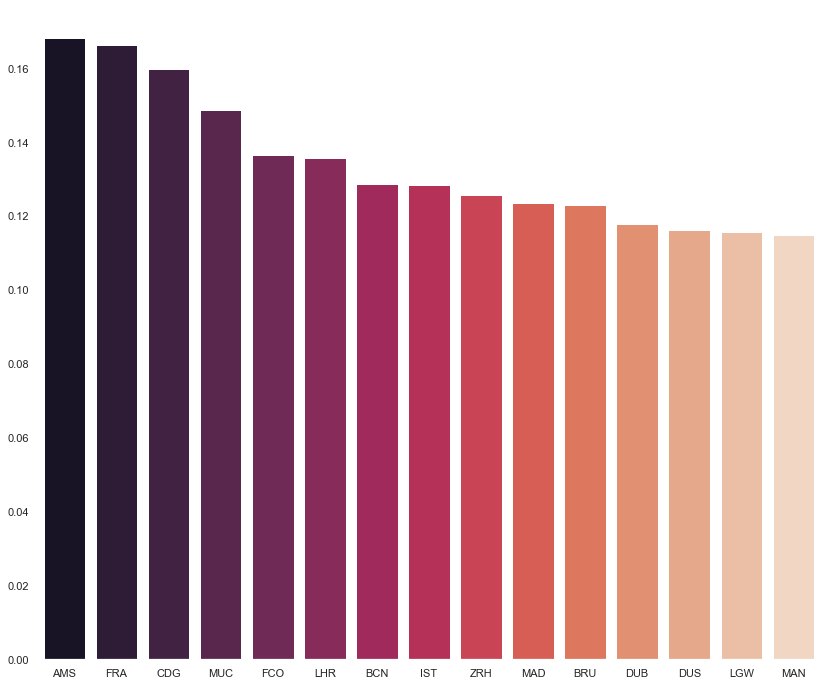

In [23]:
eigenval = nx.eigenvector_centrality(largest_cc)
sorted_eigen = plot_dict(eigenval, 15, 'eigenvectors')

**PageRank**:

PageRank is a variant of eigenvalue centrality

In terms of PageRank, the top 15 nodes are:

1. Hartsfield Jackson Atlanta International Airport, Atlanta
2. Chicago O'Hare International Airport, Chicago
3. Dallas Fort Worth International Airport, Dallas-Fort Worth
4. Atatürk International Airport, Istanbul
5. Denver International Airport, Denver
6. Charles de Gaulle International Airport, Paris
7. Domodedovo International Airport, Moscow
8. Amsterdam Airport Schiphol, Amsterdam
9. Frankfurt am Main International Airport, Frankfurt
10. Dubai International Airport, Dubai
11. Beijing Capital International Airport, Beijing
12. George Bush Intercontinental Houston Airport, Houston
13. Los Angeles International Airport, Los Angeles
14. Sydney Kingsford Smith International Airport, Sydney
15. Lester B. Pearson International Airport, Toronto


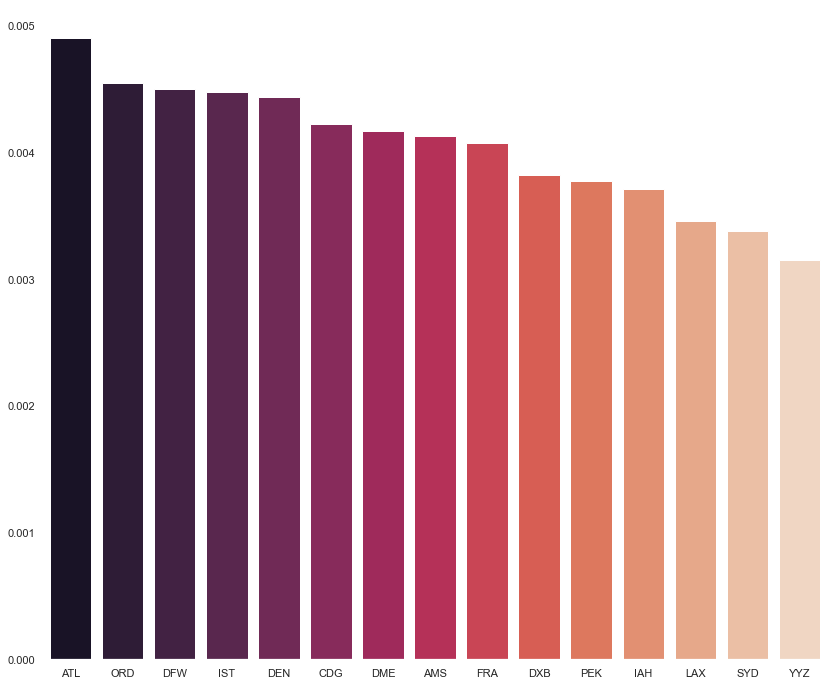

In [24]:
pagerank = nx.pagerank(largest_cc)
sorted_pagerank = plot_dict(pagerank, 15, 'PageRank')

Next we create a dataframe comprised of the metrics calculated above.

In [25]:
betw_df = pd.DataFrame(sorted_betw, columns=['Airport ID', 'Betweenness'])
eigen_df = pd.DataFrame(sorted_eigen, columns=['Airport ID', 'EigenVectors'])
pr_df = pd.DataFrame(sorted_pagerank, columns=['Airport ID', 'PageRank'])

central_df = [betw_df, eigen_df, pr_df]
df_final = reduce(lambda left, right: pd.merge(left, right, on='Airport ID'), central_df)
df_final['Average'] = (df_final['Betweenness'] + df_final['EigenVectors'] + df_final['PageRank'])/3
df_final.sort_values('Average', inplace=True)
df_final.reset_index(drop=True, inplace=True)
df_final['Overall Rank'] = np.array(df_final.index) + 1
df_final.set_index('Airport ID', inplace=True)
city_name = pd.Series(df_final.index).apply(lambda x : str(f"{get_NameCity(x)[0]}, {get_NameCity(x)[1]}"))
df_final.reset_index(inplace=True)
df_final['Airport Name, City'] = city_name
df_final.set_index('Airport ID', inplace=True)
df_final.head(15)

,Betweenness,EigenVectors,PageRank,Average,Overall Rank,"Airport Name, City"
Airport ID,,,,,,
CDG,1,3,6,3.333333,1,"Charles de Gaulle International Airport, Paris"
AMS,6,1,8,5.000000,2,"Amsterdam Airport Schiphol, Amsterdam"
FRA,5,2,9,5.333333,3,"Frankfurt am Main International Airport, Frank..."
IST,10,8,4,7.333333,4,"Atatürk International Airport, Istanbul"
DXB,3,20,10,11.000000,5,"Dubai International Airport, Dubai"
ORD,8,28,2,12.666667,6,"Chicago O'Hare International Airport, Chicago"
LHR,12,6,20,12.666667,7,"London Heathrow Airport, London"
YYZ,9,29,15,17.666667,8,"Lester B. Pearson International Airport, Toronto"
PEK,7,37,11,18.333333,9,"Beijing Capital International Airport, Beijing"


## World Map

To plot the network on the map, first we need the coordinates from the airports dataframe.

In [26]:
pos = {airport: (v['Longitude'], v['Latitude'])
    for airport, v in airports.to_dict('index').items()}

The node size will be the degree of the nodes

In [27]:
deg = nx.degree(largest_cc)
sizes = [5 * deg[iata] for iata in largest_cc.nodes]

We'll only display the label if the node size is big

In [28]:
labels = {iata: iata if deg[iata] >= 200 else '' for iata in largest_cc.nodes}

In [55]:
def display_map(graph, node_color=None):
    # Map projection
    fig, ax = plt.subplots(1, 1, figsize=(36, 24), 
    subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax.coastlines()

    nx.draw_networkx(graph, ax=ax, font_size=18, font_weight='bold', alpha=0.5, width=0.1,
    node_size=sizes, labels=labels,  pos=pos, node_color=node_color, edge_color='dimgray')

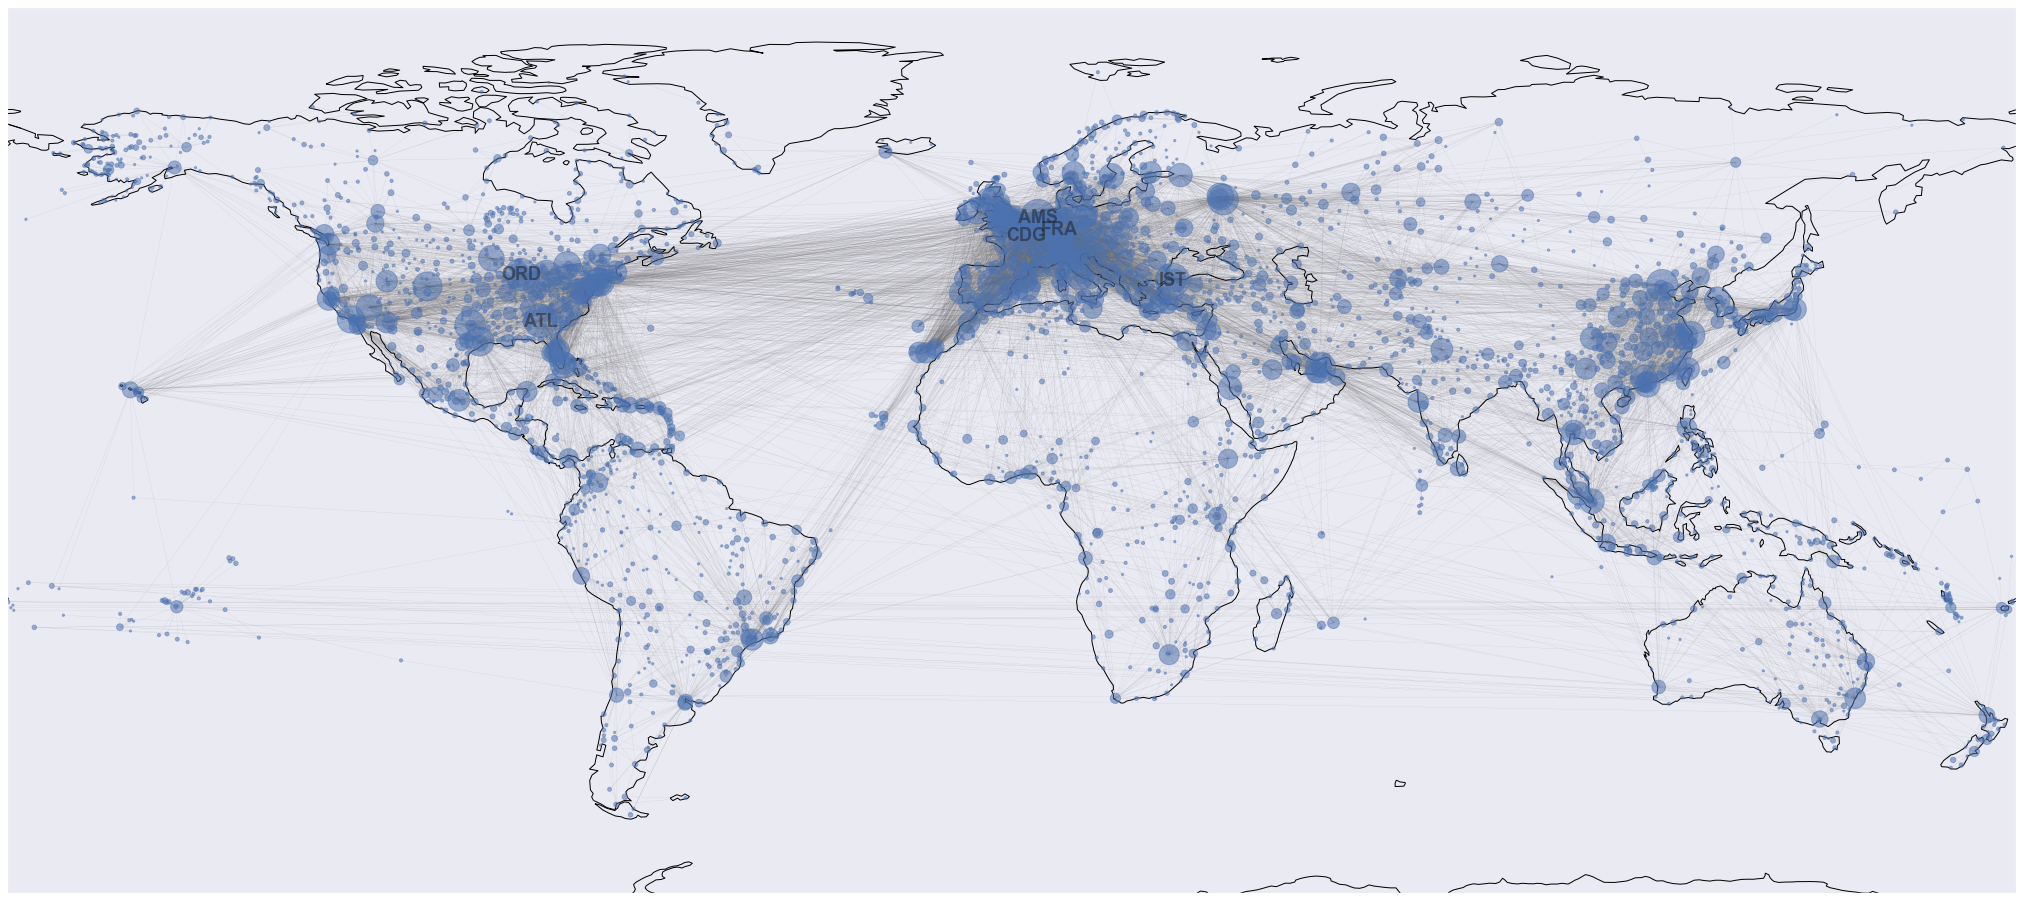

In [36]:
display_map(largest_cc)

## Finding Communities

### Spectral Clustering

1. Calculate the Laplacian (or the normalized Laplacian)
2. Calculate the first *k* eigenvectors (the eigenvectors corresponding to the *k* smallest eigenvalues of *L*)
3. Consider the matrix formed by the first *k* eigenvectors; the l-th row defines the features of graph node *l*
4. Cluster the graph nodes based on these features (e.g., using k-means clustering)

#### Laplacian

In [37]:
laplacian = nx.laplacian_matrix(largest_cc)
laplacian = laplacian.asfptype()

#### Embedding

We'll compute an embedding of the graph, in order to visualize it in 2D and also to use a representation in higher dimension, for clustering

In [38]:
def compute_embedding(laplacian, n_dim):

    # Compute the first k eigenvectors (k depends on the target dimension)
    k_eigenvalues, k_eigenvectors = scipy.sparse.linalg.eigsh(laplacian, k=1+n_dim, which='SA')

    # Compute the embedding for each node
    embedding = np.zeros((3154, n_dim))
    for i in range(3154):
        for kth in range(n_dim):
            embedding[i, kth] = k_eigenvectors[i, 1+kth]
    
    return embedding

In [40]:
embedding = compute_embedding(laplacian, 4)

In [45]:
# Laplacian eigenmaps (2D coordinates)
coords = embedding[:, 0:2]

def plot_signal(signal):
    """Display nodes of the graph in 2D together with the given signal"""

    nodes = nx.draw_networkx_nodes(largest_cc, dict(zip(largest_cc.nodes, coords)), node_size=30, node_color=signal)
    plt.xlabel('Value of $\lambda_1$')
    plt.ylabel('Value of $\lambda_2$')
    plt.colorbar(nodes)

We plot the 2D embedding of the graph, together with the first eigenvectors (Fourier basis) as signals. This way, we expect to see how to graph could be clustered.

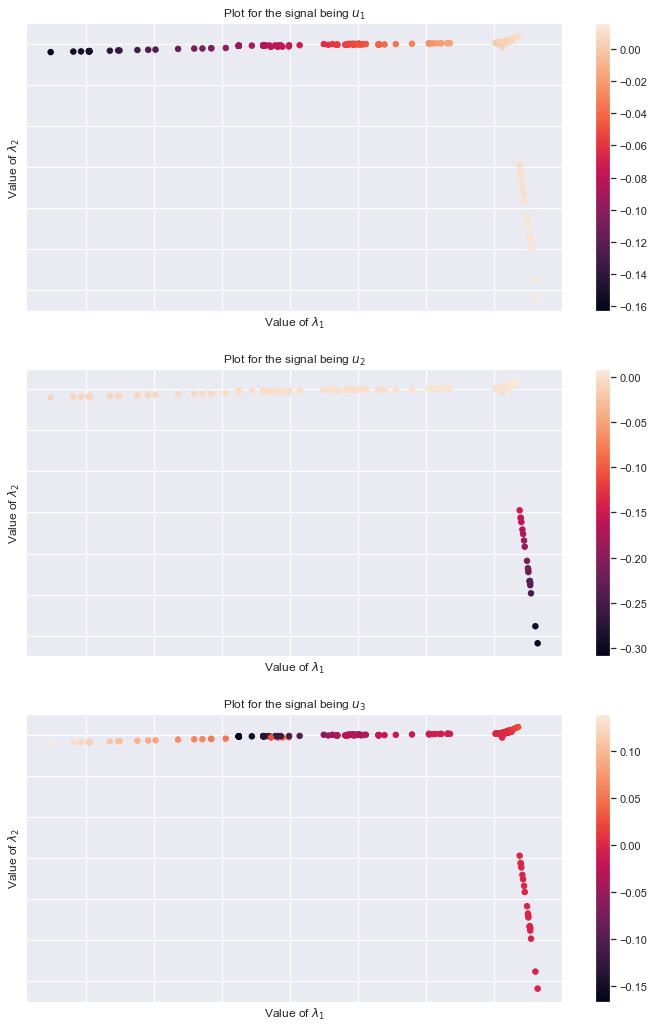

In [46]:
plt.figure(figsize=(12,18))

# Plot the first 3 Fourier basis vectors
for i in range(3):
    plt.subplot(311 + i)
    plot_signal(embedding[:, i])
    plt.title(f'Plot for the signal being $u_{i + 1}$')
plt.show()

In [47]:
predictions_gmm = GMM(n_components=3, covariance_type='full').fit_predict(embedding)

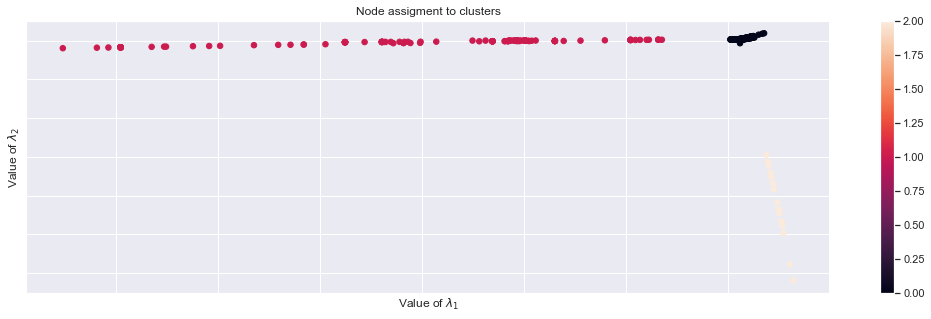

In [48]:
plt.figure(figsize=(18,5))
plot_signal(predictions_gmm)
plt.title('Node assigment to clusters')
plt.show()

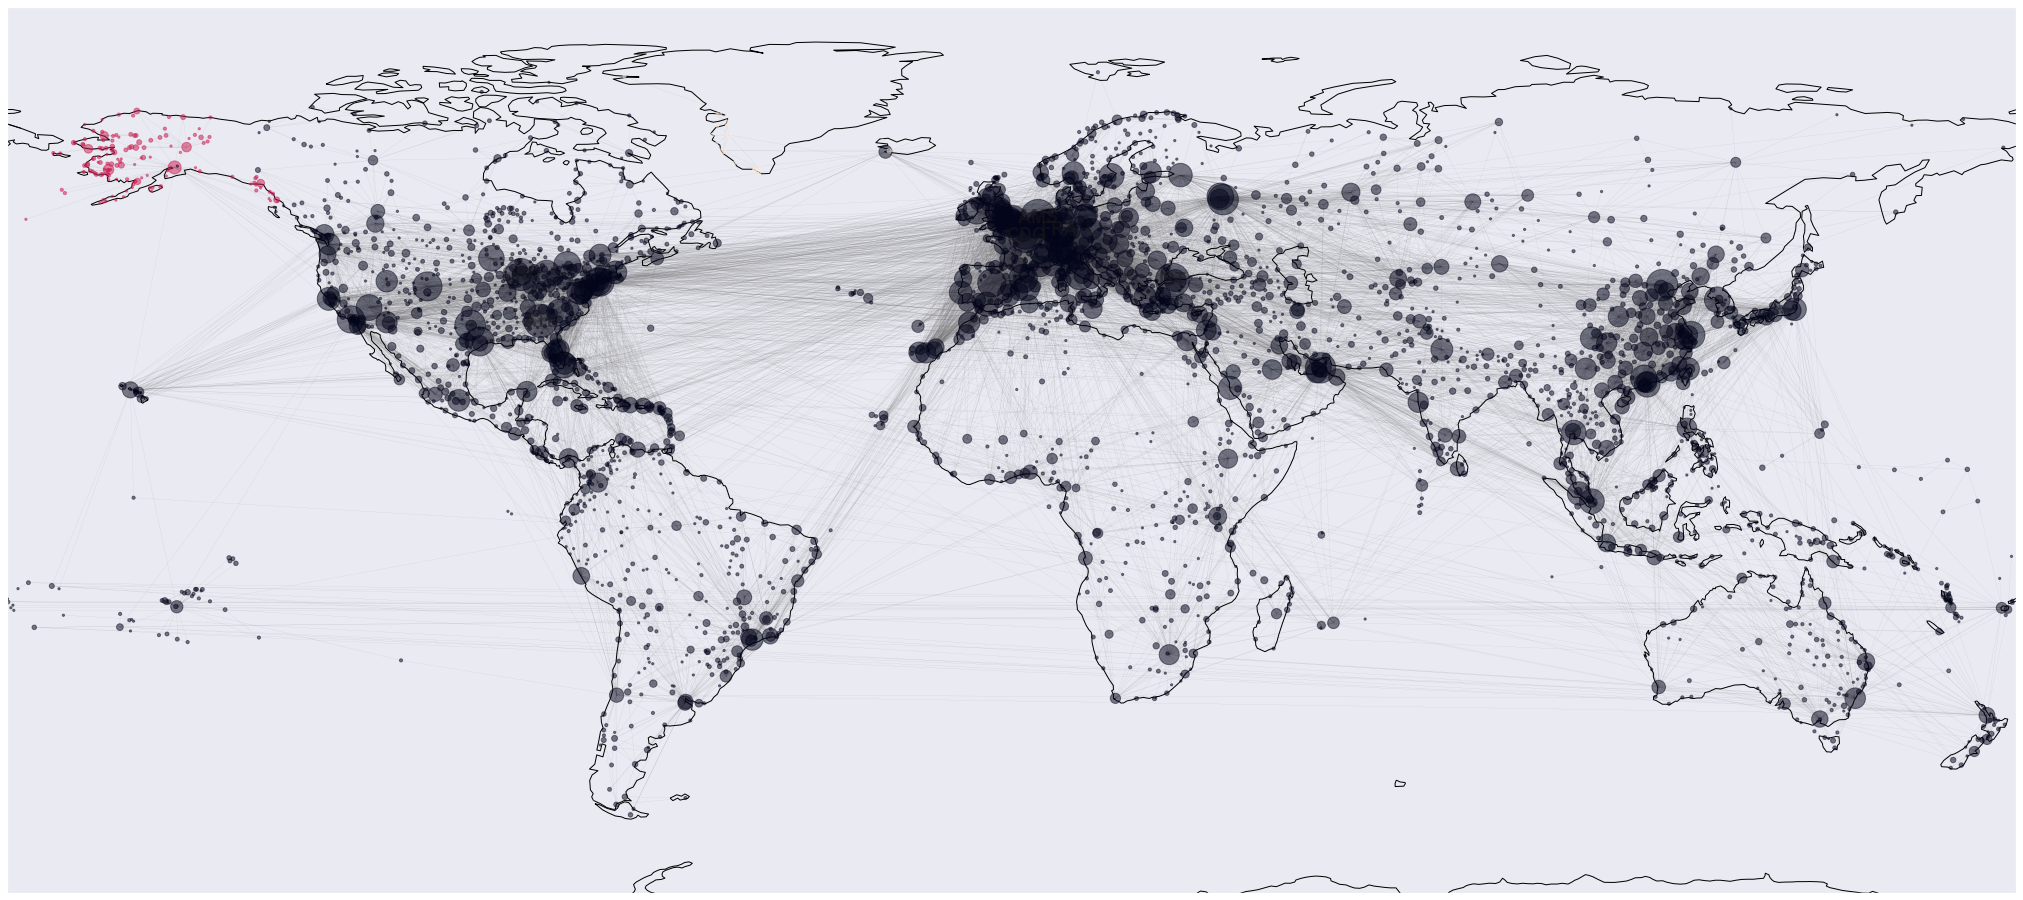

In [56]:
display_map(largest_cc, predictions_gmm)